## Load Packages

In [1]:

from __future__ import print_function
import sys
import cv2
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import csv
from PIL import Image

# Loading the Data

Once the code is functional this is the only cell that should need to be changed.
For simplicty the renaming of the output files is also here, so files don't get overwritten.

In [2]:
# Give an output name CHANGE THIS FOR NEW DATA
OutputfileName = "Demonstration"

# Sometimes the array loads but does not remove the header
HeaderRows = 15

In [3]:
## Load Fiducials
Locations = "TAEPull_MS10_Fiducials.xlsx"
FinalData = np.array(pd.read_excel(Locations))
FinalData = FinalData[HeaderRows:,:]
numberOfBoxes=int((np.size(FinalData,1)-1)/2)
FinalDataSizes = np.full_like(FinalData,1)*50

##Load Swimmer Data
Locations = "TAEPull_MS10_Position.xlsx"
FinalDataM = np.array(pd.read_excel(Locations))
FinalDataM = FinalDataM[HeaderRows:,:]
numberOfBoxes=int((np.size(FinalData,1)-1)/2)
FinalDataSizesM = np.full_like(FinalData,1)*50

##Load Magnetic Fiducial Data
Locations = "TAEPull_MS10_MagFiducials.xlsx"
FinalDataMag = np.array(pd.read_excel(Locations))
FinalDataMag = FinalDataMag[HeaderRows:,:]
numberOfBoxesMag=int((np.size(FinalData,1)-1)/2)
FinalDataSizesM = np.full_like(FinalData,1)*50


##Load the data about the Magnetic Field Direction
Locations = "DirectionField.xlsx"
FieldData = np.array(pd.read_excel(Locations))
FieldData = FieldData[HeaderRows:,:]
XMinSwim = int(30000/(FieldData[2,0]-FieldData[1,0]))
XMaxSwim = int(85000/(FieldData[2,0]-FieldData[1,0]))


##Load the data about the Magnetic Field
Locations = "MagPull_MS16_Angle_2.xlsx"
FieldData = np.array(pd.read_excel(Locations))
FieldData = FieldData[HeaderRows:,:]
XMinSwim = int(30000/(FieldData[2,0]-FieldData[1,0]))
XMaxSwim = int(85000/(FieldData[2,0]-FieldData[1,0]))
SwimmerOrientation = FieldData[4:,:]

# Analyze the Data
* Turn the data from global posistion data into the tracked points relative posistion from the start
* Calculate spacial awarness data to preserve information about the distance between points 
* Calculate the velocity and direction of all tracked objects relative to each other


In [4]:
# Analyze Fiducials

## It is important all the arrays are the same size
EndPoint= np.min([np.size(FinalData,0), np.size(FinalDataM,0), np.size(FinalDataMag,0), np.size(FieldData,0)])-10

# Non-Magnetic Fiducials
# Convert posistion data to relative motion
Motion = np.array(FinalData[:EndPoint,1:]-FinalData[15,1:], dtype= float)
# Break motion in to magnitudes directions and x and y vectors
Motion2 = np.sqrt( np.array(Motion[:,0::2]**2 +Motion[:,1::2]**2,dtype = np.int32))
MotionX = Motion[:,0::2]
MotionY = Motion[:,1::2]
Direction = np.array(np.arctan2(Motion[:,0::2],Motion[:,1::2])*180/3.14159,dtype = np.int32)

# Swimmer Motion
# Convert posistion data to relative motion
MotionM = np.array(FinalDataM[:EndPoint,1:]-FinalDataM[15,1:], dtype = float)
# Break motion in to magnitudes directions and x and y vectors
MotionMX = MotionM[:,0::2]
MotionMY = MotionM[:,1::2]
Motion2M = np.sqrt( np.array(MotionM[:,0::2]**2 +MotionM[:,1::2]**2,dtype = np.int32))
DirectionM = np.array(np.arctan2(MotionM[:,0::2],MotionM[:,1::2])*180/3.14159,dtype = np.int32)

# Magnetic Fiducials
# TConvert posistion data to relative motion
MotionMag = np.array(FinalDataMag[:EndPoint,1:]-FinalDataMag[15,1:], dtype = float)
# Break motion in to magnitudes directions and x and y vectors
MotionMagX = MotionMag[:,0::2]
MotionMagY = MotionMag[:,1::2]
Motion2Mag = np.sqrt( np.array(MotionMag[:,0::2]**2 +MotionMag[:,1::2]**2,dtype = np.int32))
DirectionM = np.array(np.arctan2(MotionMag[:,0::2],MotionMag[:,1::2])*180/3.14159,dtype = np.int32)



### Spacial Awarness

The motion of the microswimmer can alter the path of the fiducial. It is therefore good to know the spacial relation between microswimmers and fiducials. For more information see the Imamura, Kent 2025 ICRA paper.

In [5]:
# Find the Distance between Fiducials and Magnetic Swimmers
DistTot = np.zeros((EndPoint,np.size(Motion2,1),np.size(Motion2M,1)))
for numSwim in range(np.size(Motion2M,1)):
    DistComp = FinalData[:EndPoint,1:]-np.repeat(FinalDataM[:EndPoint,numSwim*2+1:numSwim*2+3], np.size(Motion2,1), axis=1)
    DistTot[:,:,numSwim] = np.sqrt( np.array(DistComp[:,0::2]**2 +DistComp[:,1::2]**2,dtype = float))
# If there are multiple microswimmers, we really only care about the closest one
DistTot = np.min(DistTot,2)

# Find the Distance between Magnetic Fiducials and Magnetic Swimmers
DistTotMagM = np.zeros((EndPoint,np.size(Motion2Mag,1),np.size(Motion2M,1)))
for numSwim in range(np.size(Motion2M,1)):
    DistComp = FinalDataMag[:EndPoint,1:]-np.repeat(FinalDataM[:EndPoint,numSwim*2+1:numSwim*2+3], np.size(Motion2Mag,1), axis=1)
    DistTotMagM[:,:,numSwim] = np.sqrt(np.array(DistComp[:,0::2]**2 +DistComp[:,1::2]**2,dtype = float))
DistTotMagM = np.min(DistTotMagM,2)

# Find the Distance between Magnetic Fiducials and non magnetic Fiducials
DistTotMF = np.zeros((EndPoint,np.size(Motion2,1),np.size(Motion2Mag,1)))
for numMag in range(np.size(Motion2Mag,1)):
    DistComp = FinalData[:EndPoint,1:]-np.repeat(FinalDataMag[:EndPoint,numMag*2+1:numMag*2+3], np.size(Motion2,1), axis=1)
    DistTotMF[:,:,numMag] = np.sqrt( np.array(DistComp[:,0::2]**2 +DistComp[:,1::2]**2,dtype = float))
DistTotMF = np.min(DistTotMF,2)

### Flow Estimation

We condsidered serveral algorithms to compare the motion of different tracked object types (non-magnetic fiducial, magnetic fiducial, microswimmer). For the paper (Imamura, Kent et al. 2025 ICRA) we demonstrated algorithm 2 but the code for all is present here.

In [6]:
# Method 1: Net Method
# Find the median motion of each particle type in x and y 

# Non-magnetic fiducial
NetFlowX = np.median(MotionX,1)
NetFlowY = np.median(MotionY,1)
# MicroSwimmer
SwimmerX = np.median(MotionMX,1)
SwimmerY = np.median(MotionMY,1)
# MagneticFiducial
MagnetX = np.median(MotionMagX,1)
MagnetY = np.median(MotionMagY,1)
#Save the Data From Algorithm 1 (uncomment the next 3 lines if you want this file)
#NetCSVFileName="{}Median.csv".format(OutputfileName)
#MedianArray = np.stack((FinalData[:EndPoint,0], NetFlowX,NetFlowY,SwimmerX[:,0],SwimmerY,MagnetX,MagnetY))
#np.savetxt(NetCSVFileName, MedianArray,delimiter=',', header="Time [s], Fiducial X, Fiducial Y, Swimmer X, Swimmer Y, MagnetX, MagnetY")

# Method 2: Only consider fiducails a specific distance from the microswimmer
# This is because the swimmer messes up the flow field
# Here we consider a symmetric distance in pixels of the radius below
# Non-Magnetic Fiducials
ExclusionRadius = 300
AlgFlowX = np.zeros_like(NetFlowX)
AlgFlowY = np.zeros_like(NetFlowX)

for time in range(EndPoint):
    NotTooCloseToSwimmer = np.argwhere(DistTot[time,:]>ExclusionRadius)
    NotTooCloseToMagnet = np.argwhere(DistTotMF[time,:]>ExclusionRadius)    
    GoodFiducials = NotTooCloseToSwimmer
    if np.size(GoodFiducials)<1:
        GoodFiducials=np.argmax(DistTot[time,:])
    # We considered if the magnetic fiducial had an affect on the non-magnetic fiducial but found no evidence
    # GoodFiducials = np.intersect1d(NotTooCloseToSwimmer, NotTooCloseToMagnet)
    XDataTemp = MotionX[time,GoodFiducials]
    YDataTemp = MotionY[time,GoodFiducials]
    AlgFlowX[time] = np.median(XDataTemp)
    AlgFlowY[time] = np.median(YDataTemp)
#print(GoodFiducials)

    

# MagneticFiducials
AlgGradX = np.zeros_like(MagnetX)
AlgGradY = np.zeros_like(MagnetX)
for time in range(EndPoint):
    GoodMagFiducials = np.argwhere(DistTotMagM[time,:]>ExclusionRadius)
    if np.size(GoodMagFiducials)<1:
        GoodMagFiducials=np.argmax(DistTotMagM[time,:])
    XDataTemp = MotionMagX[time,GoodMagFiducials]
    YDataTemp = MotionMagY[time,GoodMagFiducials]
    AlgGradX[time] = np.median(XDataTemp)
    AlgGradY[time] = np.median(YDataTemp)

    


# Method 3: Gives higher power to the fiducials further from swimmers
# We found this unnecesarry but in a more complex system with more components it may prove fruitful

#Non-magnetic Fiducial
MinDistance = np.minimum(DistTot,DistTotMF)
FlowVelocityX = np.sum(MinDistance*Motion[:,0::2],1)/np.sum(MinDistance,1)
FlowVelocityY = np.sum(MinDistance*Motion[:,1::2],1)/np.sum(MinDistance,1)
#Magnetic Fiducial
GradVelocityX = np.sum(DistTotMagM*MotionMag[:,0::2],1)/np.sum(DistTotMagM,1)
GradVelocityY = np.sum(DistTotMagM*MotionMag[:,1::2],1)/np.sum(DistTotMagM,1)

# Save the estimated motion of the non-magnetic fiducial by the three methods to excel
NetCSVFileName="{}FlowPredictionAlg.csv".format(OutputfileName)
AlgArray = np.stack((FinalData[:EndPoint,0], NetFlowX,NetFlowY,AlgFlowX,AlgFlowY,FlowVelocityX,FlowVelocityY))
np.savetxt(NetCSVFileName, AlgArray,delimiter=',', header="Time [s], Fiducial X, Fiducial Y, IgnoreDataX, IgnoreDataY, WeightedX, WeightedY")

# Save the estimated motion of the magnetic fiducial by the three methods to excel
NetCSVFileName="{}MagneticGradientPredictionAlg.csv".format(OutputfileName)
AlgArray = np.stack((FinalData[:EndPoint,0], MagnetX,MagnetY,AlgGradX,AlgGradY,GradVelocityX,GradVelocityY))
np.savetxt(NetCSVFileName, AlgArray,delimiter=',', header="Time [s], Median X, Median Y, IgnoreDataX, IgnoreDataY, WeightedX, WeightedY")

#Put The excel file here, output data

In [7]:
# This is legacy code to subtract things, I ended up doing it in the pictures instead
# Updated Data Subtracted 
FiducialsUpdateX = MotionX-np.repeat(np.reshape(FlowVelocityX,(-1,1)), np.size(Motion2,1),1)
FiducialsUpdateY = MotionY-np.repeat(np.reshape(FlowVelocityY,(-1,1)), np.size(Motion2,1),1)
FiducialsTotalMotion = np.sqrt(FiducialsUpdateX**2+FiducialsUpdateY**2)

#SwimmerUpdateX = np.reshape(MotionM[:,0::2],(-1,1))-np.reshape(FlowVelocityX,(-1,1))
#SwimmersUpdateY = np.reshape(MotionM[:,1::2],(-1,1))-np.reshape(FlowVelocityX,(-1,1))

# Pictoral Representations of the Data
Here are a bunch of visualizations of the data, more than are found in the paper. If you are looking for the specific figures from the paper see the figures folder.

We were interested in the following ideas
1. Visualization of the motions of all the tracked points to give intuition
2. Visualization of how spacial awarness affects fiducial motion
3. Visualization of the affect of the magnetic field input on the motion
4. Visualization of the relative motion between the different types of tracked particles

To the best of my knowledge if you run the first code box here, you can pick and choose which other visualizations you would like to run

In [8]:
# You need to change this value for every file... find this point and change it
OscillatingFieldStart = 800

# Get the first frame of the video for visualization
videoPath = "TAEPull_MS13_constDirRotSine_trim.mp4"
# Create a video capture object to read videos
cap = cv2.VideoCapture(videoPath)
success, frame = cap.read()
OutputIMG=frame


# This is how many pixels are in each mm (new data should check this)
convert =2.31673

import matplotlib.cm as cm
import scipy
from scipy import stats

# Figure Setup
def get_cmap_colors(cmap_name, n):
  """Returns n colors from the specified colormap."""
  cmap = cm.get_cmap(cmap_name, n)
  return [cmap(i) for i in range(n)]

# Set the colors for the number of fiducials to keep the color consistent in later figures 
n = np.size(MotionX,1)

color = get_cmap_colors('hsv', n)
    
#Flow Predicted By the Fiducials (Change the name if you want to use a different Method)
FNetX = np.repeat(np.reshape(AlgFlowX,(-1,1)),np.size(MotionX,1),1)
FNetY = np.repeat(np.reshape(AlgFlowY,(-1,1)),np.size(MotionX,1),1)

#Same as above but the size of the swimmer
FNetX2 = np.repeat(np.reshape(AlgFlowX,(-1,1)),np.size(MotionMX,1),1)
FNetY2 = np.repeat(np.reshape(AlgFlowY,(-1,1)),np.size(MotionMX,1),1)

# Flow Predicted By the Magnetic Spheres
MNetX = np.repeat(np.reshape(AlgGradX,(-1,1)),np.size(MotionMX,1),1)
MNetY = np.repeat(np.reshape(AlgGradY,(-1,1)),np.size(MotionMX,1),1)



## 1. Get an Intuition for the Motion of the Components

### Look at the Total Displacement of the Fiducials compared to the Magnetic Swimmer
Top Row: Non-Magnetic Fiducials and MicroSwimmers (Top Row)
Bottom Row: Magnteict Fiducials and MicroSwimmers (Bottom Row)

Text(0, 0.5, 'Magnetic Distance in Y [pixels]')

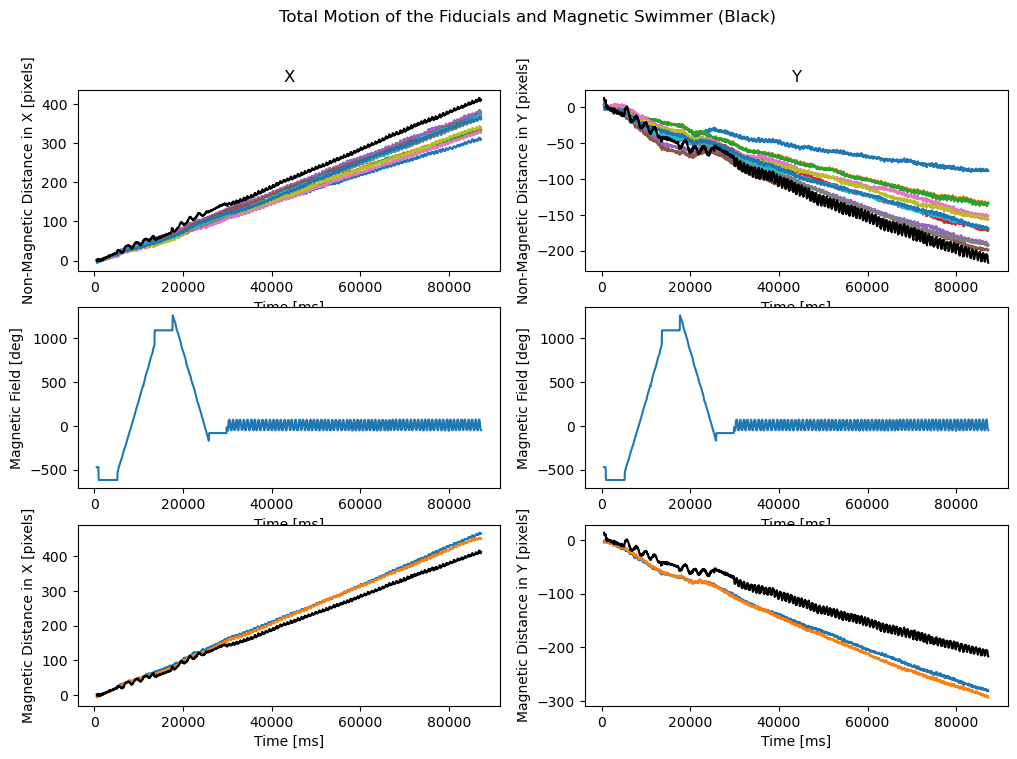

In [9]:
cols = ['{}'.format(col) for col in ['X', 'Y']]
rows = ['{}'.format(row) for row in ['Non-Magnetic', 'Magnetic Field', 'Magnetic']]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
    

fig.suptitle('Total Motion of the Fiducials and Magnetic Swimmer (Black)')
plt.subplot(3, 2, 3)
plt.plot(FieldData[:EndPoint,0],FieldData[:EndPoint,1])
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Field [deg]')

plt.subplot(3, 2, 4)
plt.plot(FieldData[:EndPoint,0],FieldData[:EndPoint,1])
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Field [deg]')

plt.subplot(3, 2, 1)
plt.plot(FinalData[:EndPoint,0],MotionX)
plt.plot(FinalData[:EndPoint,0],MotionMX[:EndPoint],'k')
#plt.ylim([-15,35])
plt.xlabel('Time [ms]')
plt.ylabel('Non-Magnetic Distance in X [pixels]')

plt.subplot(3, 2, 5)
plt.plot(FinalData[:EndPoint,0],MotionMagX[:EndPoint])
plt.plot(FinalData[:EndPoint,0],MotionMX[:EndPoint],'k')
#plt.ylim([-15,35])
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Distance in X [pixels]')

plt.subplot(3, 2, 2)
# plt.plot(FinalData[:,0],1000*FlowVelocity)
# plt.ylim([-10,35])
plt.plot(FinalData[:EndPoint,0],MotionY)
plt.plot(FinalData[:EndPoint,0],MotionMY[:EndPoint],'k')
plt.xlabel('Time [ms]')
plt.ylabel('Non-Magnetic Distance in Y [pixels]')

plt.subplot(3, 2, 6)
# plt.plot(FinalData[:,0],1000*FlowVelocity)
# plt.ylim([-10,35])
plt.plot(FinalData[:EndPoint,0],MotionMagY)
plt.plot(FinalData[:EndPoint,0],MotionMY[:EndPoint],'k')
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Distance in Y [pixels]')

## Add tight axis code

### Look at the Relative Displacement of the Fiducials and Magnetic Swimmer compared to the median motion of the fiducial type
Top Row: Non-Magnetic Fiducials and MicroSwimmers (Top Row)
Bottom Row: Magnteict Fiducials and MicroSwimmers (Bottom Row)

In [ ]:
cols = ['{}'.format(col) for col in ['X', 'Y']]
rows = ['{}'.format(row) for row in ['Non-Magnetic', 'Magnetic Field', 'Magnetic']]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)
    
    
fig.suptitle('Fiducial Motion Compared to the Flow and Swimmer (Black)')
             
plt.subplot(3, 2, 3)
plt.plot(FieldData[:EndPoint,0],FieldData[:EndPoint,1])
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Field [deg]')

plt.subplot(3, 2, 4)
plt.plot(FieldData[:EndPoint,0],FieldData[:EndPoint,1])
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Field [deg]')


plt.subplot(3, 2, 1)
plt.plot(FinalData[:EndPoint,0],MotionX-FNetX)
plt.plot(FinalData[:EndPoint,0].T,MotionMX-FNetX2,'k')
#plt.ylim([-15,35])
plt.xlabel('Time [ms]')
plt.ylabel('Non-Magnetic Relative Distance in X [pixels]')


plt.subplot(3, 2, 5)
plt.plot(FinalData[:EndPoint,0],MotionMagX-MNetX)
plt.plot(FinalData[:EndPoint,0].T,MotionMX[:EndPoint]-MNetX[:EndPoint],'k')
#plt.ylim([-15,35])
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Relative Distance in X [pixels]')



plt.subplot(3, 2, 2)
# plt.plot(FinalData[:,0],1000*FlowVelocity)
# plt.ylim([-10,35])
plt.plot(FinalData[:EndPoint,0],MotionY-FNetY)
plt.plot(FinalData[:EndPoint,0].T,(MotionMY[:EndPoint]-FNetY2[:EndPoint]), 'k')
plt.xlabel('Time [ms]')
plt.ylabel('Non-Magnetic Relative Distance in Y [pixels]')


plt.subplot(3, 2, 6)
# plt.plot(FinalData[:,0],1000*FlowVelocity)
# plt.ylim([-10,35])
plt.plot(FinalData[:EndPoint,0],MotionMagY-MNetY)
plt.plot(FinalData[:EndPoint,0].T,(MotionMY[:EndPoint]-MNetY[:EndPoint]), 'k')
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Relative Distance in Y [pixels]')





## How Well Does the Chosen Method Predict the Non-Magnetic Fiducial Motion?

2. Visualize how the spacial relationship between the microswimmer and the non-magnetic fiducials affect the outcome of the result
3. Visualize how our algorithem predicts the motion of the non-magnetic fiducial


In [ ]:
# Some calculations
FiducialErrorX = MotionX-FNetX
FiducialErrorY = MotionY-FNetY


FiducialToTError = np.sqrt(FiducialErrorX**2+FiducialErrorY**2)
TotalDistacneTraveled = np.sqrt(MotionX**2+MotionY**2)
TotalDistacneTraveled[TotalDistacneTraveled<1]=1
PercentageVelocityError= FiducialToTError/TotalDistacneTraveled

In [ ]:
# First visualize the spacial posistion of each non-magnetic fiducial and their total motion
plt.figure()

pltVal = -10
for ii in range (np.size(FiducialErrorX,1)):
    c= [color[ii]]
    if ii == 0:
        sc0=plt.scatter(FinalData[15,1+2*ii], FinalData[15,2+2*ii], color=c, s=35, marker = ".",label='start point')
        sc=plt.scatter(FinalData[pltVal,1+2*ii], FinalData[pltVal,2+2*ii], color=c, s=35, marker = "o", label='end point')
        sc2=plt.scatter(FinalData[15,1+2*ii]+FNetX[pltVal,ii], FinalData[15,2+2*ii]+FNetY[pltVal,ii], color=c, s=35, marker = '^', label='predicted end point')
    else: 
        sc0=plt.scatter(FinalData[15,1+2*ii], FinalData[15,2+2*ii], color=c, s=35, marker = ".")
        sc=plt.scatter(FinalData[pltVal,1+2*ii], FinalData[pltVal,2+2*ii], color=c, s=35, marker = "o")
        sc2=plt.scatter(FinalData[15,1+2*ii]+FNetX[pltVal,ii], FinalData[15,2+2*ii]+FNetY[pltVal,ii], color=c, s=35, marker = '^')
    


# Also visualize the posistion of the microswimmers
#print(np.shape(FinalDataM[15,1:2:-1]))
plt.scatter(FinalDataM[15,1::2], FinalDataM[15,2::2], color='k', s=35, marker = '*', label='micro-swimmer start point')
plt.scatter(FinalDataM[pltVal,1::2], FinalDataM[pltVal,2::2], color='k', s=35, marker = 'p', label='micro-swimmer end point')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

In [ ]:
# Secon visualize the swimmer trajectory over time
# it is split into the time before the swimming motion and the time after
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('Rotating Magnetic Field')
ax2.title.set_text('Osscilating Magnetic Field')

for ii in range (np.size(FiducialErrorX,1)):
    ax1.scatter(MotionX[:OscillatingFieldStart,ii], MotionY[:OscillatingFieldStart,ii], color=color[ii], s=35, marker = ".")
for ii in range(np.size(FiducialErrorX,1)): 
    ax2.scatter(MotionX[OscillatingFieldStart:,ii], MotionY[OscillatingFieldStart:,ii], color=color[ii], s=35, marker = ".")
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')
ax2.set_xlabel('X [pixels]')
ax2.set_ylabel('Y [pixels]')
plt.show()

plt.tight_layout()


In [ ]:
# Visualization of the distnce between the swimmers and the fiducials overtime
plt.rcParams.update({'font.size': 10})
numColumns=3
fig, axes = plt.subplots(nrows=(n//numColumns+1), ncols=numColumns)

if n < 4:
    for i in range(n):
        axes[i%numColumns].scatter(FinalData[:EndPoint,0]/1000,100*PercentageVelocityError[:EndPoint,i],1, color = color[i])
    #     axes[i//5,i%5].set_ylabel("Error from Estimate [%]")
    #     axes[i//5,i%5].set_xlabel("Time [s]")
        axes[i%numColumns].tick_params(axis="y", labelcolor=color[i])
        axes[i%numColumns].set_ylim(0,100)
        ax2=axes[i%numColumns].twinx()
        ax2.scatter(FinalData[:EndPoint,0]/1000,DistTot[:EndPoint,i]/convert,1,color='k')
    #     ax2.set_ylabel('$Distance from Swimmer$ [$\mu$m]',color ='k')
        ax2.tick_params(axis="y", labelcolor="k")
        ax2.axhline(y=ExclusionRadius/convert, color=[0.5,0.5,0.5], linestyle='--')
        ax2.set_ylim(0,np.max(DistTot)/convert)
else:
    for i in range(n):
        axes[i//numColumns,i%numColumns].scatter(FinalData[:EndPoint,0]/1000,100*PercentageVelocityError[:EndPoint,i],1, color = color[i])
    #     axes[i//5,i%5].set_ylabel("Error from Estimate [%]")
    #     axes[i//5,i%5].set_xlabel("Time [s]")
        axes[i//numColumns,i%numColumns].tick_params(axis="y", labelcolor=color[i])
        axes[i//numColumns,i%numColumns].set_ylim(0,100)
        ax2=axes[i//numColumns,i%numColumns].twinx()
        ax2.scatter(FinalData[:EndPoint,0]/1000,DistTot[:EndPoint,i]/convert,1,color='k')
    #     ax2.set_ylabel('$Distance from Swimmer$ [$\mu$m]',color ='k')
        ax2.tick_params(axis="y", labelcolor="k")
        ax2.axhline(y=ExclusionRadius/convert, color=[0.5,0.5,0.5], linestyle='--')
        ax2.set_ylim(0,np.max(DistTot)/convert)

    
fig.text(0.5, 0.00, "Time [s]", ha='center')
fig.text(0.00, 0.5, "Error from Estimate [%]", va='center', rotation='vertical')
fig.text(1.0, 0.5, '$Distance from Swimmer$ [$\mu$m]', va='center', rotation='vertical')
plt.tight_layout()



In [ ]:
# Graph Final Distance, dots with expected posistion vs actual
plt.figure()
for i in range (np.size(FiducialErrorX,1)):
    c = color[i]
    plt.scatter(FinalData[:EndPoint,0],100*PercentageVelocityError[:EndPoint,i],color=c)
    #plt.scatter(FinalData[:600,0],PercentYError[:600,i],linestyle='dashed',c=c)
    
plt.xlabel('Time [s]')
plt.ylabel('Percent Error [%]')
plt.ylim(0,100)


## Next we visualize the motion of the swimmer and magnetic fiducials
4. We aim to isolate how the magnetic field input affects the behavior of the microswimmer and magnetic fiducial
5. We aim to isolate the affect of the natural fluid flow, the gradient of the magnetic field and the oscillating magnetic field induced swimmin motion on the magnetic fiducials and the microswimmers.

In [ ]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(3.25,6.5))

plt.subplot(5,1,1)
plt.plot(FieldData[:,0],FieldData[:,1]*180/3.14159,color='k',linewidth=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Magnetic Field \n Orientation [$^\circ$]')

plt.subplot(5,1,2)
plt.plot(SwimmerOrientation[:707,0],SwimmerOrientation[:707,1]*180/3.14159,color = [.443,0,.467],linewidth=0.5)
plt.plot(SwimmerOrientation[707:,0],SwimmerOrientation[707:,1]*180/3.14159,color = [206.25/255,28.75/255,208.75/255],linewidth=0.5)
plt.xlabel('Time [s]')
axes[1].tick_params(axis="y", labelcolor=[.443,0,.467])
axes[1].set_ylabel('Swimmer\n Orientation [$^\circ$]',color = [.443,0,.467])


plt.subplot(5,1,3)

Regs2 = np.sqrt(FNetY[:,0]**2+FNetX[:,0]**2)
Ms=np.sqrt(FNetX[:,0]**2+FNetY[:,0]**2)
axes[2].plot(FinalData[:EndPoint,0],Regs2/convert,color = 'b', linewidth=0.5)
if np.size(MotionY,1)>1:
    Regs = np.mean(np.sqrt(MotionY[:,GoodFiducials]**2+MotionX[:,GoodFiducials]**2),1)
    RegsX = np.mean(MotionX[:,GoodFiducials],1)
    RegsY = np.mean(MotionY[:,GoodFiducials],1)
    Dir = np.arctan2(RegsY,RegsX)
    RegStd = np.std(np.sqrt(MotionY[:,1:]**2+MotionX[:,1:]**2),1)
    axes[2].fill_between(np.linspace(0,FinalData[EndPoint,0],EndPoint), (Regs2-RegStd).flatten()/convert, (Regs2+RegStd).flatten()/convert, color = 'b', alpha=.25)
else:
    pass
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('$\Delta_{ps} $ [$\mu$m]',color = [83/250,19/250,211/250])
axes[2].tick_params(axis="y", labelcolor=[83/250,19/250,211/250])


plt.subplot(5,1,4)
colorG=np.ones((2,3))*[0,1,0]
colorG[1,:]=colorG[1,:]*.5
Mags = np.sqrt(MotionMagY**2+MotionMagX**2)
Regs2 = np.sqrt(MNetX[:,0]**2+MNetY[:,0]**2)

axes[3].plot(FinalData[:EndPoint,0],Regs2/convert,color = [0.94,0.03,0.03], linewidth=0.5)
if np.size(MotionMagY,1)>1:
    Reg2Std = np.std(np.sqrt(MotionMagY**2+MotionMagX**2),1)
    axes[3].fill_between(FinalData[:EndPoint,0].astype(float), (Regs2.astype(float)-Reg2Std.astype(float)).flatten()/convert, (Regs2.astype(float)+Reg2Std.astype(float)).flatten()/convert, color = 'r', alpha =.25)
else:
    pass
axes[3].set_xlabel('Time [s]')
axes[3].set_ylabel('$\Delta_{Mag}-\Delta_{ps}$ [$\mu$m]',color = [240/250,8/250,0/250])
axes[3].tick_params(axis="y", labelcolor=[240/250,8/250,0/250])


plt.subplot(5,1,5)
Ms = np.sqrt(MotionMY**2+MotionMX**2)
Diff2 = np.sqrt((MotionMY[:EndPoint,:]-MNetY[:EndPoint,:])**2+(MotionMX[:EndPoint,:]-MNetX[:EndPoint,:])**2)

axes[4].plot(FinalData[:707,0],Diff2[:707]/convert,color = [.443,0,.467], linewidth=0.5)
axes[4].plot(FinalData[707:EndPoint,0].flatten(),Diff2[707:EndPoint]/convert,color = [206.25/255,28.75/255,208.75/255] ,linewidth=0.5)
axes[4].set_xlabel('Time [s]')
axes[4].set_ylabel('$\Delta_{Swim}-\Delta_{Mag}$ [$\mu$m]',color = [.443,0,.467])
axes[4].tick_params(axis="y", labelcolor=[.443,0,.467])
plt.tight_layout()








In [ ]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.5,4))
plt.subplot(2,2,1)
plt.plot(FieldData[:EndPoint,0]/1000,FieldData[:EndPoint,1])
plt.xlabel('Time [ms]')
plt.ylabel('Magnetic Field [deg]')

plt.subplot(2,2,3)
Ms = np.sqrt(MotionMY**2+MotionMX**2)
Diff2 = np.sqrt((MotionMY[:EndPoint,:]-MNetY[:EndPoint,:])**2+(MotionMX[:EndPoint,:]-MNetX[:EndPoint,:])**2)

axes[1,0].plot(FinalData[:OscillatingFieldStart,0],Diff2[:OscillatingFieldStart]/convert,color = [.443,0,.467], linewidth=0.5)
axes[1,0].plot(FinalData[OscillatingFieldStart:EndPoint,0].flatten(),Diff2[OscillatingFieldStart:EndPoint]/convert,color = [206.25/255,28.75/255,208.75/255] ,linewidth=0.5)
axes[1,0].set_xlabel('Time [s]')
axes[1,0].set_ylabel('$\Delta_{Swim}-\Delta_{Mag}$ [$\mu$m]',color = [.443,0,.467])
axes[1,0].tick_params(axis="y", labelcolor=[.443,0,.467])
plt.tight_layout()

plt.subplot(1,2,2)
XAverage=np.median(MotionX,1)
YAverage=np.median(MotionY,1)
plt.plot(XAverage,YAverage,.5,color='b')
#plt.plot(MotionX[707:,1],MotionY[707:,1],.5,color='b')
if np.size(MotionX,1)>1:
    STDEVX=(np.std(MotionX[:,GoodFiducials],1))
    STDEVY=np.std(MotionY[:,GoodFiducials],1)
    SummarySTDEV=np.sqrt(np.square(STDEVX)+np.square(STDEVY))
    plt.fill_between(XAverage, (YAverage.flatten()-SummarySTDEV.flatten()), (YAverage.flatten()+SummarySTDEV.flatten()), color=[.25,.25,1], alpha=.5)
else:
    pass

# plt.plot(MotionMagX[:707,0],MotionMagY[:707,0],.5,color='r')
# plt.plot(MotionMagX[707:,0],MotionMagY[707:,0],.5,color='r')


MagXAverage=np.average(MotionMagX,1)
MagYAverage=np.average(MotionMagY,1)
plt.plot(MagXAverage,MagYAverage,.5,color='r')
if np.size(MotionMagX,1)>1:
    STDEVMagX=(np.std(MotionMagX,1))
    STDEVMagY=np.std(MotionMagY,1)
    SummarySTDEV=np.sqrt(np.square(STDEVMagX)+np.square(STDEVMagY))
    plt.fill_between(MagXAverage, MagYAverage.flatten()-SummarySTDEV.flatten(), MagYAverage.flatten()+SummarySTDEV.flatten(), color=[1,.25,.25], alpha=.5)


plt.plot(MotionMX[:OscillatingFieldStart,:],MotionMY[:OscillatingFieldStart,:],.5,color=[.443,0,.467])
plt.plot(MotionMX[OscillatingFieldStart:,:],MotionMY[OscillatingFieldStart:,:],.5,color=[206.25/255,28.75/255,208.75/255])
plt.ylabel("$\Delta$ y")
plt.xlabel("$\Delta$ x")
plt.axis('equal')
plt.tight_layout()




# Summary

Here, we identify three types of objects in our analysis.
* Non-magnetic Fiducials- non-magnetic particles with no attachment to a magnet
* Magnetic Fiducials- magnetic particles with no attachment to non-magnetic particles
* Swimmers - Magnetic and Non-magnetic particles bound together

Findings:
1. Substance Flow: The flow of the liquid in which they are immersed affects all objects. 
    * The best we can tell is that size, weight, and magnetic vs. non-magnetic properties do not affect the objects' response to flow. This can be seen by looking at a set of all three particles and seeing no discernable difference between the motion of the three object types.
    * The substrate on which the magnetic swimmers are being tested appears to be sufficiently large to assume linear flow. There is no significant directional switch between the swimmers; thus, the flow is approximated linearly at this time.
    * While it was considered, spatial preferencing (such as k means) did not appear to have a significant effect on the prediction of flow velocity
    * Differently, objects moving at a rate different from the rate of flow did locally affect flow, it is therefore recommended to avoid tracking objects near swimmers and magnetic fiducials but especially swimmers, which had the largest effect on local non-magnetic particle motion
    * The motion of the fluid should not be considered consistent with time and needs to be updated in one way or another that considers change in flow over time.
2. Magnetic Gradient: Only magnetic objects (swimmers and magnetic fiducials) are affected by magnetic gradient, which pulls them in a single direction.
    * Our best assumption is that without a perfect test setup, there will be a magnetic gradient. 
    * It is assumed that the meassured response to magnetic gradient = magnetic gradient force + substance flow force
    * This is verified by subjecting magnetic particles and swimmers to a non-oscillatory magnetic field and having both the swimmer and the magnetic particles moving the same distance
    * Given the points above, you only need to track the magnetic fiducials to differentiate between swimmer and object motion
3. Swimming Motion: Only swimmers respond to the oscillatory field. 
    * From 2. It is assumed that whatever motion the swimmer performs in an oscillatory field minus the magnetic gradient is motion caused by swimming.
    
The output of the code gives numbers to quantify all 3 parameters